# Import Libs

In [2]:
import pandas as pd
import numpy as np
import os
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Load Data

In [3]:
processed_data_path = "../data/processed/combined_data.csv"

try:
    combined_df = pd.read_csv(processed_data_path, index_col = "Date", parse_dates = True)
    print("Successfully loaded combined DataFrame for feature selection.")
except FileNotFoundError:
    print(f"Error: File {processed_data_path} not found. Run preprocessing notebook.")

# Separation of features (X) and target variable (y)
X = combined_df.drop("target", axis = 1)
y = combined_df["target"]

# Chronological division of data
train_size = int(0.8 * len(combined_df))

X_train = X.iloc[:train_size]
X_test = X.iloc[train_size:]
y_train = y.iloc[:train_size]
y_test = y.iloc[train_size:]

print(f"\nData chronological split complete.")
print(f"Training set size: {len(X_train)} ({len(X_train)/len(combined_df):.2%})")
print(f"Test set size: {len(X_test)} ({len(X_test)/len(combined_df):.2%})")

Successfully loaded combined DataFrame for feature selection.

Data chronological split complete.
Training set size: 3939 (80.00%)
Test set size: 985 (20.00%)


# Train a model to select features

In [4]:
# Create a Random Forest model to determine feature importance

feature_selector_model = RandomForestClassifier(n_estimators = 100, random_state = 42, n_jobs = -1)
feature_selector_model.fit(X_train, y_train)

# Use SelectFromModel to select features with higher than average importance
sfm = SelectFromModel(feature_selector_model, threshold = "median")
sfm.fit(X_train, y_train)

# Transform the data to use only the selected features
X_train_selected = sfm.transform(X_train)
X_test_selected = sfm.transform(X_test)

# Map indexes back to feature names
selected_features_mask = sfm.get_support()
selected_features = X_train.columns[selected_features_mask]

print(f"\nOriginal Features ({len(X_train.columns)}): {X_train.columns.tolist()}")
print(f"\nSelected features ({len(selected_features)}): {selected_features.tolist()}")


Original Features (8): ['Close', 'Volume', 'Daily_Return', 'SMA_5', 'SMA_10', 'SMA_20', 'RSI', 'MACD']

Selected features (4): ['Volume', 'Daily_Return', 'RSI', 'MACD']


# Train and evaluate a new model with the selected features


--- Model Results with Selected Features ---
Accuracy: 0.4954
Precision: 0.4744
Recall: 0.5522
F1-Score: 0.5103


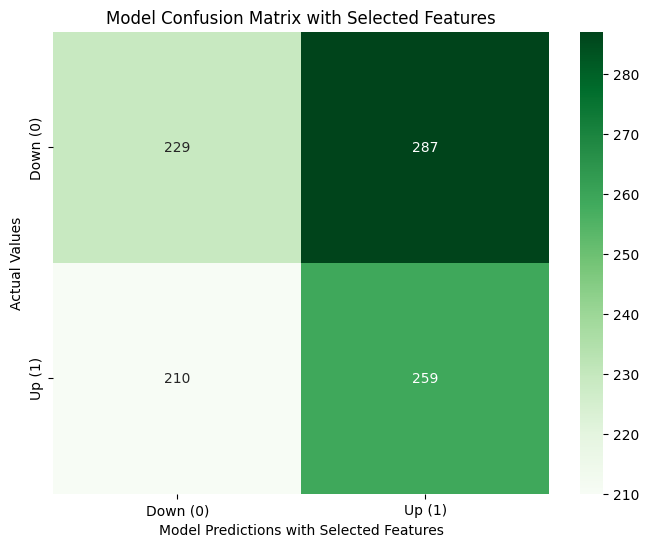


Confusion Matrix:
[[229 287]
 [210 259]]


In [6]:
# Instantiate and train a new Random Forest with the selected features
selected_model = RandomForestClassifier(n_estimators = 100, random_state = 42, n_jobs = -1)
selected_model.fit(X_train_selected, y_train)

# Make predictions on the test set with the selected features, calculate and display performance metrics.
y_pred_selected = selected_model.predict(X_test_selected)

accuracy_selected = accuracy_score(y_test, y_pred_selected)
precision_selected = precision_score(y_test, y_pred_selected)
recall_selected = recall_score(y_test, y_pred_selected)
f1_selected = f1_score(y_test, y_pred_selected)

print("\n--- Model Results with Selected Features ---")
print(f"Accuracy: {accuracy_selected:.4f}")
print(f"Precision: {precision_selected:.4f}")
print(f"Recall: {recall_selected:.4f}")
print(f"F1-Score: {f1_selected:.4f}")

# Generate and visualize the Confusion Matrix for the selected model
conf_matrix_selected = confusion_matrix(y_test, y_pred_selected)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_selected, annot=True, fmt='d', cmap='Greens',
        xticklabels=['Down (0)', 'Up (1)'],
        yticklabels=['Down (0)', 'Up (1)'])
plt.xlabel('Model Predictions with Selected Features')
plt.ylabel('Actual Values')
plt.title('Model Confusion Matrix with Selected Features')
plt.show()

print("\nConfusion Matrix:")
print(conf_matrix_selected)